In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Parameters
Change based on system

In [2]:
EPOCHS = 10 # Do not change unless testing
BATCH_SIZE = 200 # Based on system 
DATASET_PATH = "./dataset/" # Based on system

IMAGE_SHAPE = (64, 64, 3) # Should not change
LATENT_DIM = 512 # Do not change unless testing, the smaller the better

# Load Data
Done in batches

In [3]:
from keras.utils import image_dataset_from_directory

x_train, x_test = image_dataset_from_directory(
    DATASET_PATH, 
    labels=None, 
    batch_size=BATCH_SIZE, 
    image_size=IMAGE_SHAPE[:-1], 
    shuffle=False, # Don't think this matters
    validation_split=0.1, 
    subset="both",
    crop_to_aspect_ratio=True)

Found 202599 files belonging to 1 classes.
Using 182340 files for training.
Using 20259 files for validation.


In [4]:
# Normalize dataset
x_train = x_train.map(lambda x: x/255)
x_test = x_test.map(lambda x: x/255)

Show a few images from the dataset

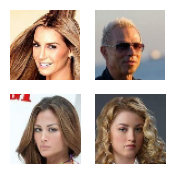

In [5]:
# Need to investigate memory usage, but should be good
train_iter, test_iter = x_train.as_numpy_iterator(), x_test.as_numpy_iterator()

fig = plt.figure(figsize=(2, 2))

plt.subplot(2, 2, 1)
plt.imshow(next(train_iter)[0]) # First image of batch 0 of x_train
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(next(train_iter)[1]) # Second image of batch 1 of x_train for variety's sakes
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(next(test_iter)[0]) # First image of batch 0 of x_test
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(next(test_iter)[1]) # Second image of batch 1 of x_test for variety's sakes
plt.axis('off')

plt.show()

# Model Definition

In [6]:
from keras import models, layers, Model

### Encoder Model

In [7]:
encoder = models.Sequential([
    layers.InputLayer(input_shape=IMAGE_SHAPE),
    layers.Conv2D(16, 3, 2, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64, 3, 2, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(128, 3, 2, padding='same', activation='relu'),
    layers.Flatten(),
], name="face_encoder")

encoder.summary()

Model: "face_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          9280      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 512)              

### Decoder Model

In [8]:
decoder = models.Sequential([
    layers.InputLayer(input_shape=(LATENT_DIM)),
    layers.Reshape((1, 1, LATENT_DIM)),
    layers.Conv2DTranspose(64, 3, 2, padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(32, 5, 4, padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(16, 5, 4, padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(3, 3, 2, padding='same', activation='sigmoid'),
], name="face_decoder")

decoder.summary()

Model: "face_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 1, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 2, 2, 64)          294976    
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 2, 2, 64)          256       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2, 2, 64)          0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 8, 8, 32)          51232     
 Transpose)                                                      
                                                      

### Variational Autoencoder Subclassing
Allow for the use of the Keras model API

In [9]:
class Autoencoder(Model):
  def __init__(self, encoder_model, decoder_model):
    super().__init__()
    self.encoder = encoder_model
    self.decoder = decoder_model

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

  def train_step(self, data):
    train_data = (data, data) # Im too lazy to customize dataset behaviour
    return super().train_step(train_data)

  def test_step(self, data):
    test_data = (data, data) # Im too lazy to customize dataset behaviour
    return super().test_step(test_data)

autoencoder = Autoencoder(encoder, decoder)
# Paper points: loss functions
autoencoder.compile(optimizer='adam', loss='mae')

# Train Model

In [10]:
autoencoder.fit(x_train,
                epochs=EPOCHS,
                validation_data=x_test)

Epoch 1/10
912/912 [==============================] - 76s 83ms/step - loss: 0.0941 - val_loss: 0.0790
Epoch 2/10
912/912 [==============================] - 83s 91ms/step - loss: 0.0757 - val_loss: 0.0728
Epoch 3/10
912/912 [==============================] - 86s 94ms/step - loss: 0.0721 - val_loss: 0.0700
Epoch 4/10
912/912 [==============================] - 84s 91ms/step - loss: 0.0700 - val_loss: 0.0684
Epoch 5/10
912/912 [==============================] - 86s 94ms/step - loss: 0.0685 - val_loss: 0.0674
Epoch 6/10
912/912 [==============================] - 82s 90ms/step - loss: 0.0674 - val_loss: 0.0661
Epoch 7/10
912/912 [==============================] - 82s 89ms/step - loss: 0.0665 - val_loss: 0.0652
Epoch 8/10
912/912 [==============================] - 82s 90ms/step - loss: 0.0658 - val_loss: 0.0646
Epoch 9/10
912/912 [==============================] - 83s 91ms/step - loss: 0.0652 - val_loss: 0.0640
Epoch 10/10
912/912 [==============================] - 83s 91ms/step - loss: 0.064

# Test Model 

In [11]:
decoded_imgs = autoencoder.predict(x_test)

102/102 [==============================] - 4s 42ms/step


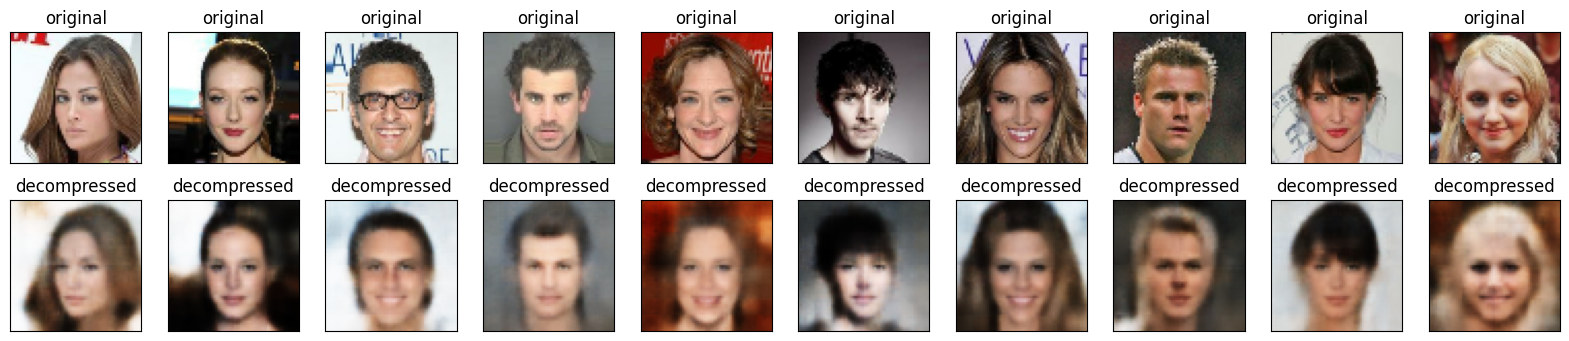

In [12]:
x_test_iterator = x_test.as_numpy_iterator()
test_batch = next(x_test_iterator)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(test_batch[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("decompressed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()